In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
from pylab import rcParams

In [ ]:
from keras import backend as K
import tensorflow as tf
from keras import optimizers, Sequential
from keras.models import Model, load_model
from keras.utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

In [ ]:
from keras.layers import Input, Layer, InputSpec
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers, activations, initializers, constraints
from keras.constraints import UnitNorm, Constraint

In [ ]:
from numpy.random import seed
seed(123)

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.215

In [ ]:
rcParams['figure.figsize'] = 8, 6
LABELS = ["Do not treat","Apply a treatment"]

In [ ]:
df = pd.read_excel('/content/meknes ( wheat data ).xlsx',header=0)
# columns = ['Location']


In [ ]:
df.head()

,datetime,tempmax,tempmin,temp,dew,humidity,precip,disease
0,2018-01-01,16.0,9.0,11.9,9.8,86.7,0.0,0
1,2018-01-02,20.0,6.0,11.7,5.2,68.8,0.0,0
2,2018-01-03,18.0,5.9,11.5,5.5,68.9,0.0,0
3,2018-01-04,18.0,5.0,10.5,7.9,85.4,0.0,0
4,2018-01-05,18.9,5.0,11.4,8.5,84.0,0.0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  730 non-null    object 
 1   tempmax   730 non-null    float64
 2   tempmin   730 non-null    float64
 3   temp      730 non-null    float64
 4   dew       730 non-null    float64
 5   humidity  730 non-null    float64
 6   precip    730 non-null    float64
 7   disease   730 non-null    int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 45.8+ KB


In [ ]:
df.drop('datetime', inplace=True, axis=1)


In [ ]:
#data shifting
sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by):
    '''
    This function will shift the binary labels in a dataframe.
    The curve shift will be with respect to the 1s.
    For example, if shift is -2, the following process
    will happen: if row n is labeled as 1, then
    - Make row (n+shift_by):(n+shift_by-1) = 1.
    - Remove row n.
    i.e. the labels will be shifted up to 2 rows up.
   Inputs:
    df       A pandas dataframe with a binary labeled column.
             This labeled column should be named as 'y'.
    shift_by An integer denoting the number of rows to shift.

    Output
    df       A dataframe with the binary labels shifted by shift.
    '''
    vector = df['disease'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'disease'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df


In [ ]:
'''
Shift the data by 2 units, equal to 4 minutes.

Test: Testing whether the shift happened correctly.
'''
print('Before shifting')  # Positive labeled rows before shifting.
one_indexes = df.index[df['disease'] == 1]
display(df.iloc[(one_indexes[0]-3):(one_indexes[0]+2), 0:5].head(n=5))

# Shift the response column y by 5 rows to do a 5-days ahead prediction.
df = curve_shift(df, shift_by = -5)

print('After shifting')  # Validating if the shift happened correctly.
display(df.iloc[(one_indexes[0]-4):(one_indexes[0]+1), 0:5].head(n=5))


Before shifting


,tempmax,tempmin,temp,dew,humidity
112,20.0,7.9,14.4,11.0,81.5
113,19.0,12.0,14.8,13.0,89.7
114,17.0,10.9,14.2,12.8,91.9
115,21.0,12.9,16.5,13.9,85.8
116,22.0,10.0,17.2,15.0,87.7


After shifting


,disease,tempmax,tempmin,temp,dew
111,1.0,17.0,12.0,14.6,12.8
112,1.0,20.0,7.9,14.4,11.0
113,1.0,19.0,12.0,14.8,13.0
114,1.0,17.0,10.9,14.2,12.8
116,0.0,22.0,10.0,17.2,15.0


In [ ]:
input_X = df.loc[:, df.columns != 'disease'].values  # converts the df to a numpy array
input_y = df['disease'].values

n_features = input_X.shape[1]  # number of features

def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

In [ ]:
'''
Test: The 3D tensors (arrays) for LSTM are forming correctly.
'''
print('First instance of y = 1 in the original data')
display(df.iloc[(np.where(np.array(input_y) == 1)[0][0]-5):(np.where(np.array(input_y) == 1)[0][0]+1), ])

lookback = 5  # Equivalent to 10 min of past data.
# Temporalize the data
X, y = temporalize(X = input_X, y = input_y, lookback = lookback)

print('For the same instance of y = 1, we are keeping past 5 samples in the 3D predictor array, X.')
display(pd.DataFrame(np.concatenate(X[np.where(np.array(y) == 1)[0][0]], axis=0 )))

First instance of y = 1 in the original data


,disease,tempmax,tempmin,temp,dew,humidity,precip
105,0.0,21.0,7.0,15.1,12.2,84.8,0.0
106,0.0,25.0,9.9,17.6,13.6,79.8,0.0
107,0.0,27.0,11.9,19.5,12.4,66.0,0.0
108,0.0,26.0,11.0,19.4,12.7,67.2,0.0
109,0.0,22.0,14.2,17.6,13.2,77.5,0.0
110,1.0,16.0,12.9,13.9,13.2,96.0,0.0


For the same instance of y = 1, we are keeping past 5 samples in the 3D predictor array, X.


,0,1,2,3,4,5
0,25.0,9.9,17.6,13.6,79.8,0.0
1,27.0,11.9,19.5,12.4,66.0,0.0
2,26.0,11.0,19.4,12.7,67.2,0.0
3,22.0,14.2,17.6,13.2,77.5,0.0
4,16.0,12.9,13.9,13.2,96.0,0.0


In [ ]:
#Divide the data into train, valid, and test
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size= 0.3, random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size= 0.3, random_state=SEED)
X_train.shape

X_train_y0 = X_train[y_train==0]
X_train_y1 = X_train[y_train==1]

X_valid_y0 = X_valid[y_valid==0]
X_valid_y1 = X_valid[y_valid==1]

X_train_y0.shape

(346, 5, 1, 6)

In [ ]:
#Reshaping data
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)

X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)

In [ ]:
# Standardize the data
def flatten(X):
    '''
    Flatten a 3D array.

    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.

    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize

    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])

    return X

In [ ]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_train_y0))
X_train_y0_scaled = scale(X_train_y0, scaler)
X_train_y1_scaled = scale(X_train_y1, scaler)
X_train_scaled = scale(X_train, scaler)

In [ ]:
'''
Test: Check if the scaling is correct.

The test succeeds if all the column means
and variances are 0 and 1, respectively, after
flattening.
'''
a = flatten(X_train_y0_scaled)
print('colwise mean', np.mean(a, axis=0).round(6))
print('colwise variance', np.var(a, axis=0))

X_valid_scaled = scale(X_valid, scaler)
X_valid_y0_scaled = scale(X_valid_y0, scaler)

X_test_scaled = scale(X_test, scaler)

colwise mean [-0. -0.  0. -0. -0. -0.]
colwise variance [1. 1. 1. 1. 1. 1.]


In [ ]:
#LSTM Autoencoder training
timesteps =  X_train_y0_scaled.shape[1]
n_features =  X_train_y0_scaled.shape[2]
epochs = 300
batch = 32
lr = 0.001

In [ ]:
lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(32, activation='sigmoid', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(16, activation='sigmoid', return_sequences=False))
lstm_autoencoder.add(RepeatVector(timesteps))
# Decoder
lstm_autoencoder.add(LSTM(16, activation='sigmoid', return_sequences=True))
lstm_autoencoder.add(LSTM(32, activation='sigmoid', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 5, 32)             4992      
                                                                 
 lstm_21 (LSTM)              (None, 16)                3136      
                                                                 
 repeat_vector_5 (RepeatVec  (None, 5, 16)             0         
 tor)                                                            
                                                                 
 lstm_22 (LSTM)              (None, 5, 16)             2112      
                                                                 
 lstm_23 (LSTM)              (None, 5, 32)             6272      
                                                                 
 time_distributed_5 (TimeDi  (None, 5, 6)              198       
 stributed)                                           

In [ ]:
adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer= adam)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled,
                                                epochs=epochs,
                                                batch_size=batch,
                                                validation_data=(X_valid_y0_scaled, X_valid_y0_scaled),
                                                verbose=2).history

Epoch 1/300
11/11 - 7s - loss: 1.0857 - val_loss: 1.0069 - 7s/epoch - 649ms/step
Epoch 2/300
11/11 - 0s - loss: 1.0142 - val_loss: 0.9697 - 185ms/epoch - 17ms/step
Epoch 3/300
11/11 - 0s - loss: 0.9942 - val_loss: 0.9616 - 167ms/epoch - 15ms/step
Epoch 4/300
11/11 - 0s - loss: 0.9906 - val_loss: 0.9603 - 176ms/epoch - 16ms/step
Epoch 5/300
11/11 - 0s - loss: 0.9903 - val_loss: 0.9608 - 174ms/epoch - 16ms/step
Epoch 6/300
11/11 - 0s - loss: 0.9889 - val_loss: 0.9609 - 166ms/epoch - 15ms/step
Epoch 7/300
11/11 - 0s - loss: 0.9878 - val_loss: 0.9595 - 172ms/epoch - 16ms/step
Epoch 8/300
11/11 - 0s - loss: 0.9874 - val_loss: 0.9590 - 160ms/epoch - 15ms/step
Epoch 9/300
11/11 - 0s - loss: 0.9865 - val_loss: 0.9567 - 245ms/epoch - 22ms/step
Epoch 10/300
11/11 - 0s - loss: 0.9857 - val_loss: 0.9562 - 292ms/epoch - 27ms/step
Epoch 11/300
11/11 - 0s - loss: 0.9830 - val_loss: 0.9527 - 266ms/epoch - 24ms/step
Epoch 12/300
11/11 - 0s - loss: 0.9799 - val_loss: 0.9493 - 307ms/epoch - 28ms/step
Epo

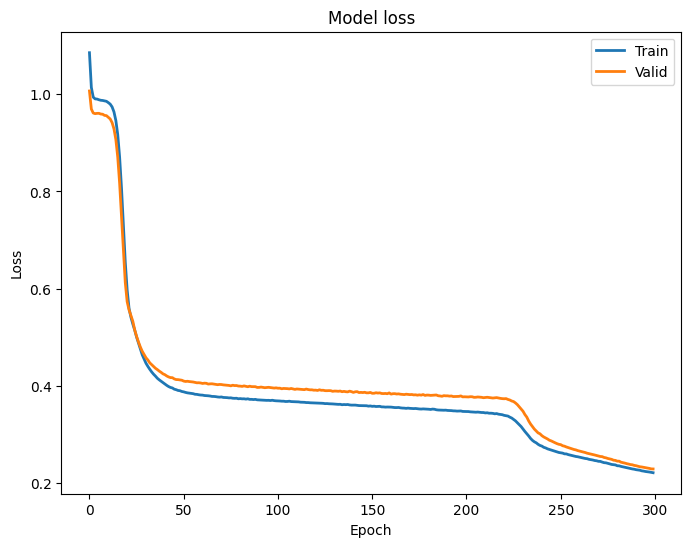

In [ ]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

5/5 [==============================] - 1s 9ms/step


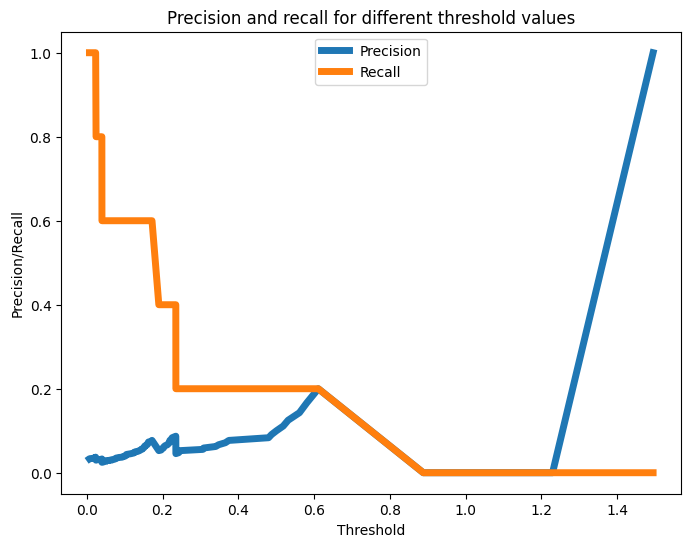

In [ ]:
valid_x_predictions = lstm_autoencoder.predict(X_valid_scaled)
mse = np.mean(np.power(flatten(X_valid_scaled) - flatten(valid_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_valid.tolist()})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

7/7 [==============================] - 0s 4ms/step


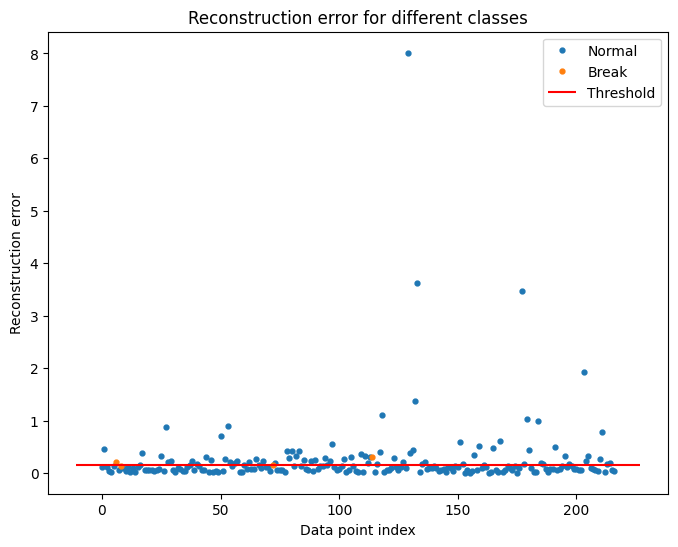

In [ ]:
test_x_predictions = lstm_autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(flatten(X_test_scaled) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test.tolist()})

threshold_fixed = 0.15
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();


In [ ]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]


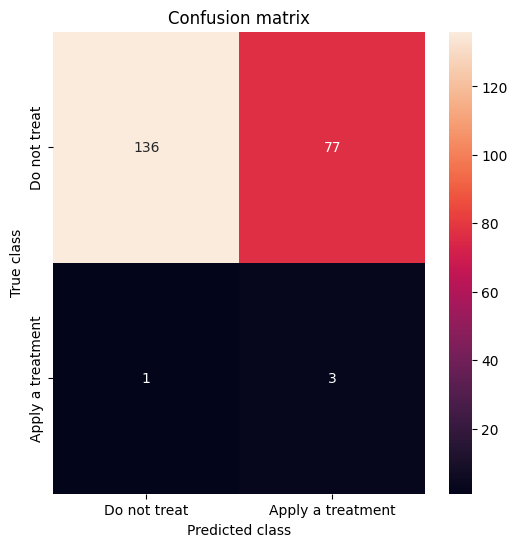

In [ ]:
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


In [ ]:
conf_matrix

array([[134,  79],
       [  1,   3]])

In [ ]:
# MSE Loss calculation
mse_loss = np.mean(mse)
print("MSE Loss:", mse_loss)

MSE Loss: 0.24260299969645852


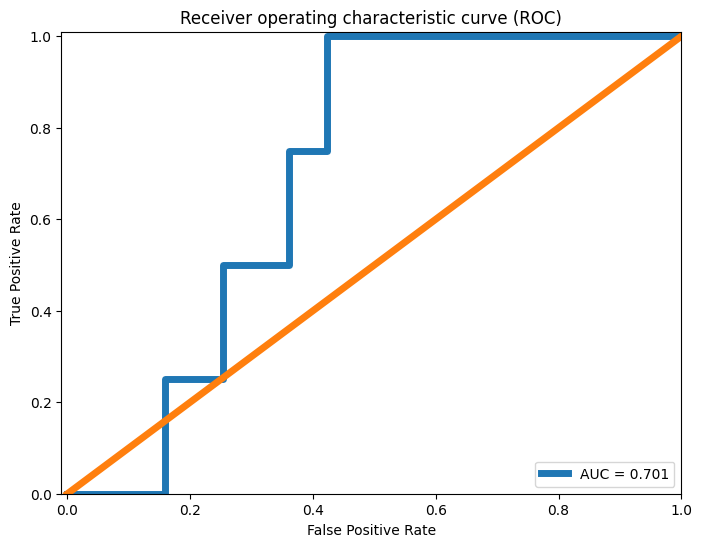

In [ ]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()